### Introdução à Engenharia Biomédica (P4 - 2021/2022)
# Aula Prática #5 - Extração de Features de Biosinais

Name: (write here)

IST ID: (write here)

Date: (write here)

# I. Overview
<br>
<div class="title"style="width:100%; background:linear-gradient(to right,#FDC86E,#fbb144);font-family:'arial black',monospace; text-align: center; padding: 7px 0; border-radius: 5px 50px;margin-top:-15px" >  </div>

# <div style="color:#fbb144"> 1. Introduction </div>

Time and frequency representations of signals often contain valuable information that can be more easily extracted and analyzed. Such information can be statistical measures (e.g., mean, maximum and minimum amplitudes, variance), and be related to the nature and morphology of the signal (e.g., location of P, QRS, and T waves, series of RR intervals – for ECG).

Regarding biosignals, this is an extremely important task when developing automatic methods for physiological monitoring and medical diagnosis. In this class you will be presented with some biosignal processing and feature extraction tools for biomedical research.

<img src="https://usq.pressbooks.pub/app/uploads/sites/39/2021/01/gram-1024x723.png" style="width:70%">
<a href="https://usq.pressbooks.pub/anatomy/chapter/6-2-cardiac-muscle-and-electrical-activity/">Reference</a>

# <div style="color:#fbb144"> 2. Objectives</div>

* Understand the objective of feature extraction in the context of biosignals

* Get acquainted with the main BioSPPy capabilities for biosignals

# II. BioSPPy for ECG Signals
<br>
<div class="title"style="width:100%; background:linear-gradient(to right,#FDC86E,#fbb144);font-family:'arial black',monospace; text-align: center; padding: 7px 0; border-radius: 5px 50px;margin-top:-15px" >  </div>

<img src="https://raw.githubusercontent.com/PIA-Group/BioSPPy/master/docs/logo/logo_400.png"/>

Python is often referred to as "the batteries included language", meaning that there are plenty of useful modules either bundled or contributed by the community. Biosignals are no exception and some libraries already bundle basic signal processing and analytics components.

The ECG module available in BioSPPy provides methods for ECG processing (visualization, filtering, segmentation, etc.).


Make sure you have BioSSPy installed. If not, run the following command in a code cell:

```python
!pip install biosppy
```

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import biosppy as bp

Let's load an ECG file and use the function `signals.ecg.ecg()`, that calls several functions that automatically filter the signal, find R peaks, compute the instantaneous heart rate and segments the ECG waveforms. This function also provides an interactive interface to visualize its outputs.

In [18]:
# Load file
fs = 1000. # Hz
ecg_op3 = np.loadtxt('resources/ecg_op3.csv')

# To use external viewer
%matplotlib

# BioSPPy
bp.signals.ecg.ecg(ecg_op3, fs, show=True);

Using matplotlib backend: Qt5Agg


<img src="resources/biosppy_ecg.png" style="width:80%"/>

Let's explore how this function works:

```python
def ecg(signal=None, sampling_rate=1000., path=None, show=True):
    """Process a raw ECG signal and extract relevant signal features using
    default parameters.

    Parameters
    ----------
    signal : array
        Raw ECG signal.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    path : str, optional
        If provided, the plot will be saved to the specified file.
    show : bool, optional
        If True, show a summary plot.

    Returns
    -------
    ts : array
        Signal time axis reference (seconds).
    filtered : array
        Filtered ECG signal.
    rpeaks : array
        R-peak location indices.
    templates_ts : array
        Templates time axis reference (seconds).
    templates : array
        Extracted heartbeat templates.
    heart_rate_ts : array
        Heart rate time axis reference (seconds).
    heart_rate : array
        Instantaneous heart rate (bpm).

    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    # ensure numpy
    signal = np.array(signal)

    sampling_rate = float(sampling_rate)

    # filter signal
    order = int(0.3 * sampling_rate)
    filtered, _, _ = st.filter_signal(signal=signal,
                                      ftype='FIR',
                                      band='bandpass',
                                      order=order,
                                      frequency=[3, 45],
                                      sampling_rate=sampling_rate)

    # segment
    rpeaks, = hamilton_segmenter(signal=filtered, sampling_rate=sampling_rate)

    # correct R-peak locations
    rpeaks, = correct_rpeaks(signal=filtered,
                             rpeaks=rpeaks,
                             sampling_rate=sampling_rate,
                             tol=0.05)

    # extract templates
    templates, rpeaks = extract_heartbeats(signal=filtered,
                                           rpeaks=rpeaks,
                                           sampling_rate=sampling_rate,
                                           before=0.2,
                                           after=0.4)

    # compute heart rate
    hr_idx, hr = st.get_heart_rate(beats=rpeaks,
                                   sampling_rate=sampling_rate,
                                   smooth=True,
                                   size=3)

    # get time vectors
    length = len(signal)
    T = (length - 1) / sampling_rate
    ts = np.linspace(0, T, length, endpoint=True)
    ts_hr = ts[hr_idx]
    ts_tmpl = np.linspace(-0.2, 0.4, templates.shape[1], endpoint=False)

    # plot
    if show:
        plotting.plot_ecg(ts=ts,
                          raw=signal,
                          filtered=filtered,
                          rpeaks=rpeaks,
                          templates_ts=ts_tmpl,
                          templates=templates,
                          heart_rate_ts=ts_hr,
                          heart_rate=hr,
                          path=path,
                          show=True)

    # output
    args = (ts, filtered, rpeaks, ts_tmpl, templates, ts_hr, hr)
    names = ('ts', 'filtered', 'rpeaks', 'templates_ts', 'templates',
             'heart_rate_ts', 'heart_rate')

    return utils.ReturnTuple(args, names)
```

We can retrieve all outputs using a single output variable:

In [3]:
# BioSPPy
ecg_data = np.loadtxt('resources/ecg_op3.csv')
out = bp.signals.ecg.ecg(ecg_data, fs, show=False)
out.keys()

['ts',
 'filtered',
 'rpeaks',
 'templates_ts',
 'templates',
 'heart_rate_ts',
 'heart_rate']

This way we can perform our own operations:

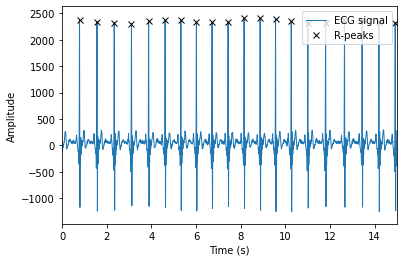

In [4]:
# Extract data
t = out['ts']
ecg_filtered = out['filtered']
rpeaks = out['rpeaks']

# Plot
%matplotlib inline

plt.plot(t, ecg_filtered, color='tab:blue', linewidth=1, label='ECG signal')
plt.plot(t[rpeaks], ecg_filtered[rpeaks],'kx', label='R-peaks')
plt.xlim([0,15])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

In [23]:
out['ts']

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 5.9597e+01, 5.9598e+01,
       5.9599e+01])

In [5]:
rpeaks

array([  781,  1563,  2337,  3108,  3877,  4616,  5322,  6018,  6720,
        7437,  8154,  8873,  9564, 10267, 11010, 11806, 12652, 13443,
       14195, 14925, 15653, 16372, 17080, 17777, 18475, 19272, 20081,
       20912, 21681, 22441, 23195, 23929, 24654, 25320, 25970, 26626,
       27308, 28002, 28692, 29360, 30033, 30733, 31490, 32261, 32989,
       33677, 34356, 35048, 35746, 36435, 37102, 37767, 38455, 39187,
       39900, 40576, 41235, 41905, 42662, 43419, 44163, 44868, 45541,
       46196, 46845, 47482, 48110, 48731, 49354, 49977, 50607, 51245,
       51905, 52599, 53333, 54058, 54761, 55470, 56212, 56971, 57691,
       58389, 59096])

In [6]:
t[rpeaks]

array([ 0.781,  1.563,  2.337,  3.108,  3.877,  4.616,  5.322,  6.018,
        6.72 ,  7.437,  8.154,  8.873,  9.564, 10.267, 11.01 , 11.806,
       12.652, 13.443, 14.195, 14.925, 15.653, 16.372, 17.08 , 17.777,
       18.475, 19.272, 20.081, 20.912, 21.681, 22.441, 23.195, 23.929,
       24.654, 25.32 , 25.97 , 26.626, 27.308, 28.002, 28.692, 29.36 ,
       30.033, 30.733, 31.49 , 32.261, 32.989, 33.677, 34.356, 35.048,
       35.746, 36.435, 37.102, 37.767, 38.455, 39.187, 39.9  , 40.576,
       41.235, 41.905, 42.662, 43.419, 44.163, 44.868, 45.541, 46.196,
       46.845, 47.482, 48.11 , 48.731, 49.354, 49.977, 50.607, 51.245,
       51.905, 52.599, 53.333, 54.058, 54.761, 55.47 , 56.212, 56.971,
       57.691, 58.389, 59.096])

An alternative is to directly use the functions of the `ecg` module, that also contains other methods for signal segmentation, feature extraction and signal quality assessment.

In [7]:
dir(bp.signals.ecg)

['ASI_segmenter',
 'ZZ2018',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_extract_heartbeats',
 'absolute_import',
 'argrelextrema',
 'bSQI',
 'christov_segmenter',
 'compare_segmentation',
 'correct_rpeaks',
 'division',
 'ecg',
 'engzee_segmenter',
 'extract_heartbeats',
 'fSQI',
 'gamboa_segmenter',
 'getPPositions',
 'getQPositions',
 'getSPositions',
 'getTPositions',
 'hamilton_segmenter',
 'integrate',
 'kSQI',
 'math',
 'np',
 'pSQI',
 'plotting',
 'plt',
 'print_function',
 'range',
 'sSQI',
 'ss',
 'ssf_segmenter',
 'st',
 'stats',
 'utils',
 'zip']

#### EXERCISE

1. Load the `ecg_op2.csv` ($fs=1000 Hz$) into the variable `ecg_op2` (7th column) and then, using the `ecg` BioSSPy module, run the `ecg()` function and save the output into the variable `ecg_out`.

2. Using matplotlib's functionalities, use the `templates_ts` and `templates` outputs to replicate the `ecg` template window. Note that you should transpose both arrays. Use the following plot style:
* color = (your choice)
* linewidth = 1
* alpha = 0.08 (transparency)

*Hint: you can use the `.T` method to transpose NumPy arrays.*

array([[ 40.7771826 ,  41.58987519,  42.75156128, ..., 104.39677889,
        105.16757934, 105.48283619],
       [ 47.88657833,  50.6016717 ,  53.12087294, ...,  62.39575881,
         63.1410977 ,  64.6552597 ],
       [ 62.78252634,  62.2614302 ,  61.40015373, ...,  87.57297559,
         89.23879466,  90.97599946],
       ...,
       [ 44.94071949,  42.41504159,  40.04104141, ...,  98.34583829,
         99.91884714, 101.39744724],
       [ 27.66556585,  23.95696581,  21.06083947, ...,  90.25769098,
         90.7480259 ,  91.31546612],
       [ 69.03053044,  68.32468367,  67.12538025, ...,  65.00996502,
         64.28558466,  64.60317968]])

3. Aditionally, use the `np.mean()` function to add the mean template waveform to the previous plot using:
* color = 'black'
* linewidth = 1
* linestyle = '--'
* label = 'Mean'

You should provide a legend for the mean waveform.

*Hint: when using the np.mean function, use the axis parameter to compute the mean of the array columns.*

# III. Heart Rate Variability (HRV)
<br>
<div class="title"style="width:100%; background:linear-gradient(to right,#FDC86E,#fbb144);font-family:'arial black',monospace; text-align: center; padding: 7px 0; border-radius: 5px 50px;margin-top:-15px" >  </div>

Besides directly analysing ECG, the heart rate variability (HRV) is also very common and useful when dealing with heart-based signals. This signal allows to understand variations to the frequency of the ECG, which is related to alterations in the overall state of a person.

Both HR and HRV are modulated by the autonomic nervous system, which includes sympathetic and parasympathetic nerve branches. These branches innervate parts of the atria of the heart. Sympathetic stimulation increases HR and parasympathetic stimulation decreases it. In addition to the natural variations in heart rate caused by breathing, HRV appears to be sensitive to factors such as mental stress, sleep and fatigue, chronic illness, and others. Elevated HRV is also related to well-being and fitness.

HRV may be evaluated by a variety of methods. We will describe some of them below.

#### DISCUSSION:
Besides the ECG, what other signal could be used to perform HRV analysis?

# <div style="color:#fbb144"> 1. RR-Intervals (RRIs) </div>

An RR-Interval (RRI) corresponds to the time difference between two consecutive R-peaks of the ECG.

<img src="https://media.imotions.com/images/20190411122523/RR-interval.png" style="width:30%"/>

<br>
<br>

$$ RR_{i+1} = R_{i+1} - R_{i},\ \ i = 0, \ldots ,N-1 $$

In [10]:
# Extract R-peaks
rpeaks = out['rpeaks']/fs*1000 # convert sample indexes to ms

# Compute RR Intervals
rri = []
for i in range(len(rpeaks)-1):
    rri.append(rpeaks[i + 1] - rpeaks[i])

rri = np.array(rri) # convert to numpy array

rri

array([782., 774., 771., 769., 739., 706., 696., 702., 717., 717., 719.,
       691., 703., 743., 796., 846., 791., 752., 730., 728., 719., 708.,
       697., 698., 797., 809., 831., 769., 760., 754., 734., 725., 666.,
       650., 656., 682., 694., 690., 668., 673., 700., 757., 771., 728.,
       688., 679., 692., 698., 689., 667., 665., 688., 732., 713., 676.,
       659., 670., 757., 757., 744., 705., 673., 655., 649., 637., 628.,
       621., 623., 623., 630., 638., 660., 694., 734., 725., 703., 709.,
       742., 759., 720., 698., 707.])

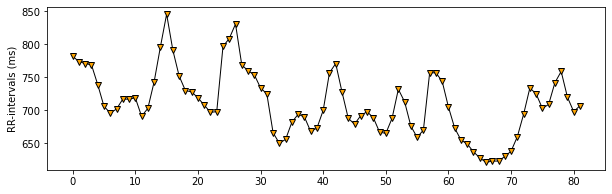

In [11]:
# Plot RRIs
plt.figure(figsize=(10,3))
plt.plot(rri, lw=1, color='k', marker='v', markerfacecolor='orange')
plt.ylabel('RR-intervals (ms)')
plt.show()

With the RRI series, we can compute statistical metrics such as mean and standard deviation:

In [12]:
# Compute mean and sd
rr_mean = np.mean(rri)
rr_sd = np.std(rri)

print(f'Mean = {rr_mean}, SD = {rr_sd}')

Mean = 711.1585365853658, SD = 48.749101183007504


We can also represent the data with a histogram:

In [24]:
# Plot histogram
bins = np.arange(np.min(rri), np.max(rri)+10, 10)

plt.hist(rri, bins, facecolor='skyblue', edgecolor='black')
plt.title('RR Distribution')
plt.xlabel('RR Interval (ms)')
plt.ylabel('Count')
plt.show()

# <div style="color:#fbb144"> 2. Heart Rate (HR) </div>

Heart Rate (HR) corresponds to the number of R-peaks that occur in a minute. Alternatively, we can compute the instantaneous Heart Rate:


$$ {HR}_{i+1} = \frac{60}{R_{i+1} - R_{i}} (bpm),\ \ i = 0, \ldots ,N-1 $$

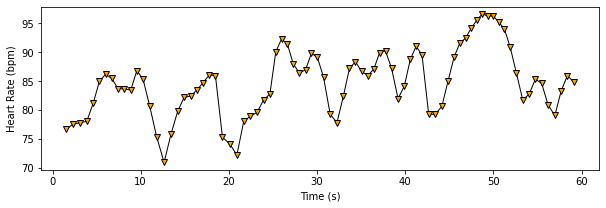

In [14]:
# Compute heart rate
ts = out['rpeaks'][1:]/fs
hr = fs * (60.0 / np.diff(out['rpeaks']))

# Plot
plt.figure(figsize=(10,3))
plt.plot(ts, hr, lw=1, color='k', marker='v', markerfacecolor='orange')
plt.ylabel('Heart Rate (bpm)')
plt.xlabel('Time (s)')
plt.show()

# <div style="color:#fbb144"> 3. Root Mean Square of Successive Differences (RMSSD) </div>

Another important feature for the analysis of HRV is the root mean square of SDs between adjacent RR-intervals (RMSSD), which reflects parasympathetic activity.

<img src="https://media.imotions.com/images/20190411122521/rmssd-walkthrough.png" style="width:40%">
<a href="https://imotions.com/blog/heart-rate-variability/">Reference</a>

$$
R M S S D=\sqrt{\frac{1}{N-1} \sum_{i=1}^{N-1}\left(R R_{i+1}-R R_{i}\right)^{2}}
$$

In [15]:
rpeaks = out['rpeaks']/fs*1000 # ms
rr_int = np.diff(rpeaks)
rr_diff = np.diff(rr_int)

rmssd = np.sqrt(np.mean(rr_diff**2))
print(f'RMSSD = {rmssd} ms')

RMSSD = 28.76833822017919 ms


# <div style="color:#fbb144"> 4. Poincaré plot </div>

Another feature to examine is the Pointcaré plot, which is generated as the plot:

$$RR_{i+1} \textrm{vs.} RR_i$$


In this plot, the standard descriptor 1 (SD1) describes the short-term variability in the R-R intervals, whereas the standard descriptor 2 (SD2) describes the long-term variability (29). SD1 mostly represents parasympathetic heart influence, whereas SD2 reflects sympathetic and parasympathetic inputs to the heart.

<img src="resources/poincare.png" style="width:30%"/>

SD1 = 20.331747897442572 
SD2 = 65.84307227137275 
Area = 4205.664996033708 
SD1/SD2 = 0.3087909964718097


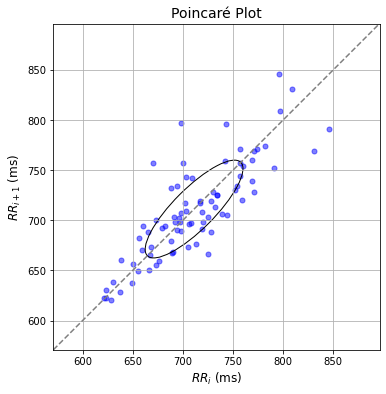

In [16]:
import matplotlib as mpl
x = rri[:-1]
y = rri[1:]
rr_mean = np.mean(rri)

# Plot
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Poincaré Plot', fontsize=14)
ax.set_xlabel('$RR_i$ (ms)', fontsize=12)
ax.set_ylabel('$RR_{i+1}$ (ms)', fontsize=12)

# Plot Poincaré data points
ax.scatter(x, y, marker='.', color='blue', alpha=0.5,s=100)
ax.set_xlim([np.min(rr_int) - 50, np.max(rr_int) + 50])
ax.set_ylim([np.min(rr_int) - 50, np.max(rr_int) + 50])
ax.set_aspect(1./ax.get_data_ratio())


# Draw RRi+1=RRi
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes

ax.plot(lims, lims, color='grey', linestyle='--')


# Draw ellipse
sd1 = np.std(np.subtract(x, y) / np.sqrt(2))
sd2 = np.std(np.add(x, y) / np.sqrt(2))
area = np.pi * sd1 * sd2


ellipse_ = mpl.patches.Ellipse((rr_mean, rr_mean), sd1 * 2, sd2 * 2, angle=-45, edgecolor='black', facecolor="None")
ax.add_artist(ellipse_)

ax.grid()

print(f'SD1 = {sd1} \nSD2 = {sd2} \nArea = {area} \nSD1/SD2 = {sd1/sd2}')



# <div style="color:#fbb144"> 5. Frequency Analysis </div>

Furthermore, frequency-domain analysis describes the high and low frequency (LV) rates of variability changes, which correlate to the activity of distinct ANS branches. The unique contributions of the parasympathetic and sympathetic systems were discovered by using these frequency range discrepancies in HRV studies.

<img src="https://3ap96f18gb4f131eh84bgi1n-wpengine.netdna-ssl.com/wp-content/uploads/2017/04/FFT-spectrum.png"/>

#### EXERCISE:

1. Use BioSPPy's capabilities to perform a spectral analysis of the `ecg_op2` signal. 

*Hint: Use the function `signals.tools.welch_spectrum()`.*

2. Use Matplotlib to plot the ECG spectrum.

*Hint: check the previous notebook.*

# IV. Atrial Fibrillation (AFib)
<br>
<div class="title"style="width:100%; background:linear-gradient(to right,#FDC86E,#fbb144);font-family:'arial black',monospace; text-align: center; padding: 7px 0; border-radius: 5px 50px;margin-top:-15px" >  </div>

Atrial Fibrillation (AFib) is a type of heart arrhythmia, an uncoordinated activity of the heart chambers, in which the heart presents an irregular and high-rate electrical activity of the atria. It is the most common type of heart arrhythmia in the Western World with an estimated prevalence of 46.3 million people around the globe, and it is one of the main causes of stroke since it increases the risk of having one by 4 to 5 fold.

When observing the ECG, AFib is characterized by having irregular heart rhythms, absence of P-waves, nonexistence of an isoelectric baseline and variable ventricular rate. Also, P-wave activity can be replaced by fibrillatory waves (f-waves).

<img src="resources/AFib.png" style="width:70%"/>

Since it drastically changes heart rhythm, AFib can be identified using HRV metrics:

Plot ECG


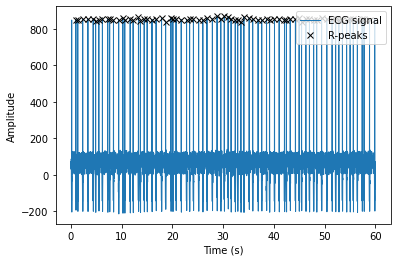

Plot Templates


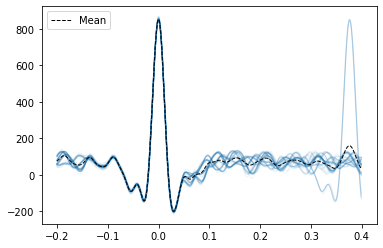

Compute RRIs
Mean = 782.3243243243244, SD = 215.91797166842858


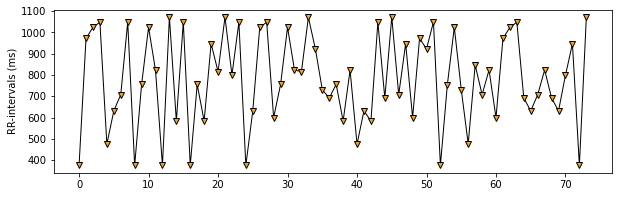

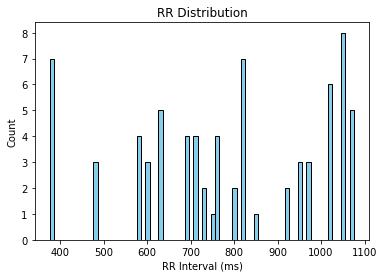

Plot HR


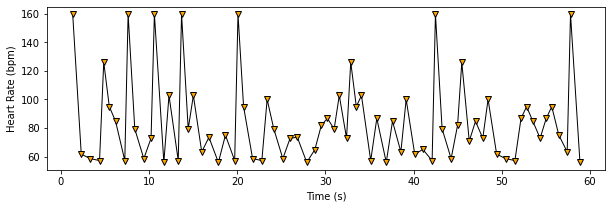

RMSSD = 334.97904248491363 ms
Plot Poincaré
SD1 = 236.7699907572222 
SD2 = 187.08432575383216 
Area = 139159.84392008392 
SD1/SD2 = 1.2655789831841233


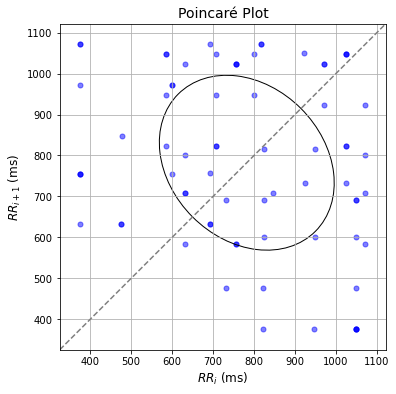

In [17]:
from functions import *

ecg_af = np.loadtxt('resources/ecg_af.csv')

plot_ecg(ecg_af, fs)
plot_templates(ecg_af, fs)
compute_rri(ecg_af, fs)
compute_hr(ecg_af, fs)
compute_rmssd(ecg_af, fs)
plot_poincare(ecg_af, fs)

# Further Reading
<br>
<div class="title"style="width:100%; background:linear-gradient(to right,#FDC86E,#fbb144);font-family:'arial black',monospace; text-align: center; padding: 7px 0; border-radius: 5px 50px;margin-top:-15px" >  </div>

* Dong, J. (2016). *The role of heart rate variability in sports physiology (Review)*. Experimental and Therapeutic Medicine, 11, 1531-1536. https://doi.org/10.3892/etm.2016.3104
* Makivic , B., &amp; Bauer, P. *Heart Rate Variability Analysis in Sport*. Aspetar Sports Medicine Journal - Heart rate variability analysis in sport. Retrieved June 6, 2022, from https://www.aspetar.com/journal/viewarticle.aspx?id=248#.Yp4f2qjMJPZ 
* Valencell. *Heart Rate Variability Review*. Retrieved June 6, 2022, from https://valencell.com/blog/heart-rate-variability-review/

<tr>
<td> <img src="https://github.com/PIA-Group/ScientIST-notebooks/blob/master/_Resources/Images/IT.png?raw=true" alt="Drawing" style="width:200px"/> </td>

<td> <img src="https://github.com/PIA-Group/ScientIST-notebooks/blob/master/_Resources/Images/IST.png?raw=true" alt="Drawing"
style="width:200px"/> </td>
</tr>

```Contributors:  ``` Ana Fred, Hugo Plácido da Silva and Rafael Silva